<a href="https://colab.research.google.com/github/rezwanh001/Kaggle-Competitions/blob/master/LANL_Earthquake_Prediction_Version_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# import tensorflow as tf
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))


In [1]:
import os
import pprint
import tensorflow as tf

if 'COLAB_TPU_ADDR' not in os.environ:
  print('ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!')
else:
  tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  print ('TPU address is', tpu_address)

  with tf.Session(tpu_address) as session:
    devices = session.list_devices()
    
  print('TPU devices:')
  pprint.pprint(devices)

TPU address is grpc://10.100.147.146:8470
TPU devices:
[_DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:CPU:0, CPU, -1, 4293893247076234153),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 15741281911253392169),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 1571668613981752594),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 6295139575021331475),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 10822339641882514908),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 6492725043429865439),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 11160243922109450771),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 4516210566738166573),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, 95901530856

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# to access kaggle datasets
!pip install kaggle

# Math operations
!pip install numpy==1.15.0

# Machine learning
!pip install catboost

In [4]:
# Colab's file access feature
from google.colab import files

# retrieve upload file
uploaded = files.upload()

#print results
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.jason into the folder where the API expects to to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/kaggle/kaggle.json 

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 65 bytes
chmod: cannot access '/root/kaggle/kaggle.json': No such file or directory


In [5]:
# list competitions
!kaggle competitions list

#download earthquake data
!kaggle competitions download -c LANL-Earthquake-Prediction

ref                                            deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
digit-recognizer                               2030-01-01 00:00:00  Getting Started  Knowledge       2532           False  
titanic                                        2030-01-01 00:00:00  Getting Started  Knowledge       9947            True  
house-prices-advanced-regression-techniques    2030-01-01 00:00:00  Getting Started  Knowledge       4099           False  
imagenet-object-localization-challenge         2029-12-31 07:00:00  Research         Knowledge         35           False  
competitive-data-science-predict-future-sales  2019-12-31 23:59:00  Playground           Kudos       2382           False  
two-sigma-financial-news                       2019-07-15 23:59:00  Featured          $100,000       2927           False  
LANL-Ear

In [6]:
#unzip training data for usage
!unzip train.csv.zip
!ls

Archive:  train.csv.zip
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
drive		       seg_4280d9.csv  seg_845a2a.csv  seg_c21723.csv
sample_data	       seg_428d66.csv  seg_8472f3.csv  seg_c21d60.csv
sample_submission.csv  seg_42c4c9.csv  seg_848695.csv  seg_c22bd4.csv
seg_00030f.csv	       seg_42e7e8.csv  seg_84a65d.csv  seg_c23429.csv
seg_0012b5.csv	       seg_42ff14.csv  seg_84b9d9.csv  seg_c23641.csv
seg_00184e.csv	       seg_430e66.csv  seg_84c7fb.csv  seg_c243a6.csv
seg_003339.csv	       seg_43383f.csv  seg_84fc12.csv  seg_c24946.csv
seg_0042cc.csv	       seg_434c96.csv  seg_8509db.csv  seg_c25855.csv
seg_004314.csv	       seg_43597f.csv  seg_850d95.csv  seg_c267a5.csv
seg_004cd2.csv	       seg_43c6f4.csv  seg_8515fd.csv  seg_c26fb4.csv
seg_004ee5.csv	       seg_440106.csv  seg_853302.csv  seg_c27591.csv
seg_004f1f.csv	       seg_4401d8.csv  seg_854d91.csv  seg_c2a0c8.csv
seg_00648a.csv	       seg_441c6d.csv  seg_857304.csv  seg_c2b8f7.csv
seg_006e4a.csv	       seg_4435

In [0]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
##======================= Import Libraries =====================================#############
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gc
import os
import time
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
from scipy import stats
from scipy.signal import hann
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from scipy.signal import convolve
from sklearn.svm import NuSVR, SVR
from catboost import CatBoostRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold,StratifiedKFold, RepeatedKFold
warnings.filterwarnings("ignore")



In [8]:
##=========================Load The Data ==============================                  
train_df=pd.read_csv('train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})
print("Train: rows:{} cols:{}".format(train_df.shape[0], train_df.shape[1]))

pd.options.display.precision = 15
train_df.head(10)


Train: rows:629145480 cols:2


,acoustic_data,time_to_failure
0,12,1.469099998474121
1,6,1.469099998474121
2,8,1.469099998474121
3,5,1.469099998474121
4,8,1.469099998474121
5,8,1.469099998474121
6,9,1.469099998474121
7,7,1.469099998474121
8,-5,1.469099998474121
9,3,1.469099998474121


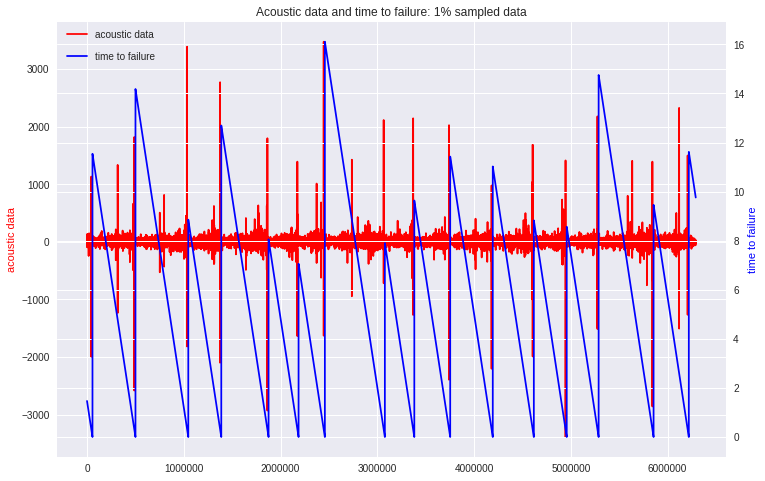

In [9]:
#######===================Data Exploration ===================================+++#############
train_ad_sample_df = train_df['acoustic_data'].values[::100]
train_ttf_sample_df = train_df['time_to_failure'].values[::100]

def plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df, title="Acoustic data and time to failure: 1% sampled data"):
    fig, ax1 = plt.subplots(figsize=(12, 8))
    plt.title(title)
    plt.plot(train_ad_sample_df, color='r')
    ax1.set_ylabel('acoustic data', color='r')
    plt.legend(['acoustic data'], loc=(0.01, 0.95))
    ax2 = ax1.twinx()
    plt.plot(train_ttf_sample_df, color='b')
    ax2.set_ylabel('time to failure', color='b')
    plt.legend(['time to failure'], loc=(0.01, 0.9))
    plt.grid(True)

plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df)
del train_ad_sample_df
del train_ttf_sample_df


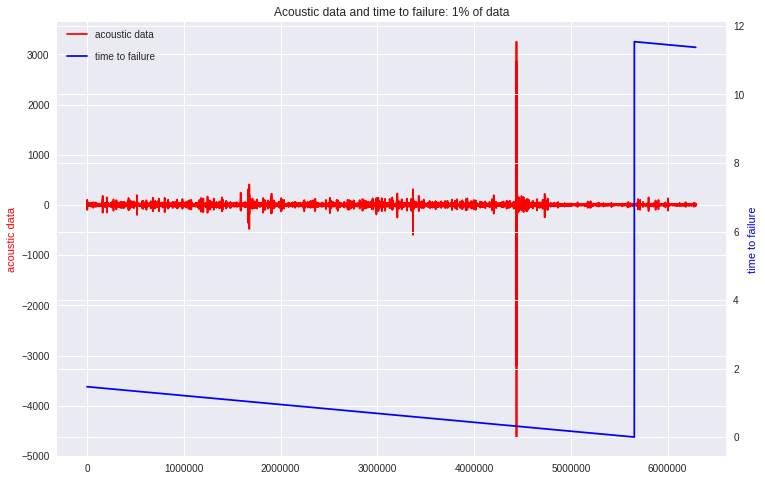

In [10]:
train_ad_sample_df = train_df['acoustic_data'].values[:6291455]
train_ttf_sample_df = train_df['time_to_failure'].values[:6291455]
plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df, title="Acoustic data and time to failure: 1% of data")
del train_ad_sample_df
del train_ttf_sample_df

In [11]:

###================ Features Engineering ======================##########
rows = 150000
segments = int(np.floor(train_df.shape[0] / rows))
print("Number of segments: ", segments)

def add_trend_feature(arr, abs_values=False):
    idx = np.array(range(len(arr)))
    if abs_values:
        arr = np.abs(arr)
    lr = LinearRegression()
    lr.fit(idx.reshape(-1, 1), arr)
    return lr.coef_[0]

def classic_sta_lta(x, length_sta, length_lta):
    sta = np.cumsum(x ** 2)
    # Convert to float
    sta = np.require(sta, dtype=np.float)
    # Copy for LTA
    lta = sta.copy()
    # Compute the STA and the LTA
    sta[length_sta:] = sta[length_sta:] - sta[:-length_sta]
    sta /= length_sta
    lta[length_lta:] = lta[length_lta:] - lta[:-length_lta]
    lta /= length_lta
    # Pad zeros
    sta[:length_lta - 1] = 0
    # Avoid division by zero by setting zero values to tiny float
    dtiny = np.finfo(0.0).tiny
    idx = lta < dtiny
    lta[idx] = dtiny
    return sta / lta

Number of segments:  4194


In [0]:

### =============== Process The train file ==================== ##########
train_X = pd.DataFrame(index=range(segments), dtype=np.float64)
train_y = pd.DataFrame(index=range(segments), dtype=np.float64, columns=['time_to_failure'])
total_mean = train_df['acoustic_data'].mean()
total_std = train_df['acoustic_data'].std()
total_max = train_df['acoustic_data'].max()
total_min = train_df['acoustic_data'].min()
total_sum = train_df['acoustic_data'].sum()
total_abs_sum = np.abs(train_df['acoustic_data']).sum()

def create_features(seg_id, seg, X):
    xc = pd.Series(seg['acoustic_data'].values)
    zc = np.fft.fft(xc)
    
    X.loc[seg_id, 'mean'] = xc.mean()
    X.loc[seg_id, 'std'] = xc.std()
    X.loc[seg_id, 'max'] = xc.max()
    X.loc[seg_id, 'min'] = xc.min()
    
    #FFT transform values
    realFFT = np.real(zc)
    imagFFT = np.imag(zc)
    X.loc[seg_id, 'Rmean'] = realFFT.mean()
    X.loc[seg_id, 'Rstd'] = realFFT.std()
    X.loc[seg_id, 'Rmax'] = realFFT.max()
    X.loc[seg_id, 'Rmin'] = realFFT.min()
    X.loc[seg_id, 'Imean'] = imagFFT.mean()
    X.loc[seg_id, 'Istd'] = imagFFT.std()
    X.loc[seg_id, 'Imax'] = imagFFT.max()
    X.loc[seg_id, 'Imin'] = imagFFT.min()
    X.loc[seg_id, 'Rmean_last_5000'] = realFFT[-5000:].mean()
    X.loc[seg_id, 'Rstd__last_5000'] = realFFT[-5000:].std()
    X.loc[seg_id, 'Rmax_last_5000'] = realFFT[-5000:].max()
    X.loc[seg_id, 'Rmin_last_5000'] = realFFT[-5000:].min()
    X.loc[seg_id, 'Rmean_last_15000'] = realFFT[-15000:].mean()
    X.loc[seg_id, 'Rstd_last_15000'] = realFFT[-15000:].std()
    X.loc[seg_id, 'Rmax_last_15000'] = realFFT[-15000:].max()
    X.loc[seg_id, 'Rmin_last_15000'] = realFFT[-15000:].min()
    
    X.loc[seg_id, 'mean_change_abs'] = np.mean(np.diff(xc))
    X.loc[seg_id, 'mean_change_rate'] = np.mean(np.nonzero((np.diff(xc) / xc[:-1]))[0])
    X.loc[seg_id, 'abs_max'] = np.abs(xc).max()
    X.loc[seg_id, 'abs_min'] = np.abs(xc).min()
    
    X.loc[seg_id, 'std_first_50000'] = xc[:50000].std()
    X.loc[seg_id, 'std_last_50000'] = xc[-50000:].std()
    X.loc[seg_id, 'std_first_10000'] = xc[:10000].std()
    X.loc[seg_id, 'std_last_10000'] = xc[-10000:].std()
    
    X.loc[seg_id, 'avg_first_50000'] = xc[:50000].mean()
    X.loc[seg_id, 'avg_last_50000'] = xc[-50000:].mean()
    X.loc[seg_id, 'avg_first_10000'] = xc[:10000].mean()
    X.loc[seg_id, 'avg_last_10000'] = xc[-10000:].mean()
    
    X.loc[seg_id, 'min_first_50000'] = xc[:50000].min()
    X.loc[seg_id, 'min_last_50000'] = xc[-50000:].min()
    X.loc[seg_id, 'min_first_10000'] = xc[:10000].min()
    X.loc[seg_id, 'min_last_10000'] = xc[-10000:].min()
    
    X.loc[seg_id, 'max_first_50000'] = xc[:50000].max()
    X.loc[seg_id, 'max_last_50000'] = xc[-50000:].max()
    X.loc[seg_id, 'max_first_10000'] = xc[:10000].max()
    X.loc[seg_id, 'max_last_10000'] = xc[-10000:].max()
    
    X.loc[seg_id, 'max_to_min'] = xc.max() / np.abs(xc.min())
    X.loc[seg_id, 'max_to_min_diff'] = xc.max() - np.abs(xc.min())
    X.loc[seg_id, 'count_big'] = len(xc[np.abs(xc) > 500])
    X.loc[seg_id, 'sum'] = xc.sum()
    
    X.loc[seg_id, 'mean_change_rate_first_50000'] = np.mean(np.nonzero((np.diff(xc[:50000]) / xc[:50000][:-1]))[0])
    X.loc[seg_id, 'mean_change_rate_last_50000'] = np.mean(np.nonzero((np.diff(xc[-50000:]) / xc[-50000:][:-1]))[0])
    X.loc[seg_id, 'mean_change_rate_first_10000'] = np.mean(np.nonzero((np.diff(xc[:10000]) / xc[:10000][:-1]))[0])
    X.loc[seg_id, 'mean_change_rate_last_10000'] = np.mean(np.nonzero((np.diff(xc[-10000:]) / xc[-10000:][:-1]))[0])
    
    X.loc[seg_id, 'q95'] = np.quantile(xc, 0.95)
    X.loc[seg_id, 'q99'] = np.quantile(xc, 0.99)
    X.loc[seg_id, 'q05'] = np.quantile(xc, 0.05)
    X.loc[seg_id, 'q01'] = np.quantile(xc, 0.01)
    
    X.loc[seg_id, 'abs_q95'] = np.quantile(np.abs(xc), 0.95)
    X.loc[seg_id, 'abs_q99'] = np.quantile(np.abs(xc), 0.99)
    X.loc[seg_id, 'abs_q05'] = np.quantile(np.abs(xc), 0.05)
    X.loc[seg_id, 'abs_q01'] = np.quantile(np.abs(xc), 0.01)
    
    X.loc[seg_id, 'trend'] = add_trend_feature(xc)
    X.loc[seg_id, 'abs_trend'] = add_trend_feature(xc, abs_values=True)
    X.loc[seg_id, 'abs_mean'] = np.abs(xc).mean()
    X.loc[seg_id, 'abs_std'] = np.abs(xc).std()
    
    X.loc[seg_id, 'mad'] = xc.mad()
    X.loc[seg_id, 'kurt'] = xc.kurtosis()
    X.loc[seg_id, 'skew'] = xc.skew()
    X.loc[seg_id, 'med'] = xc.median()
    
    X.loc[seg_id, 'Hilbert_mean'] = np.abs(hilbert(xc)).mean()
    X.loc[seg_id, 'Hann_window_mean'] = (convolve(xc, hann(150), mode='same') / sum(hann(150))).mean()
    X.loc[seg_id, 'classic_sta_lta1_mean'] = classic_sta_lta(xc, 500, 10000).mean()
    X.loc[seg_id, 'classic_sta_lta2_mean'] = classic_sta_lta(xc, 5000, 100000).mean()
    X.loc[seg_id, 'classic_sta_lta3_mean'] = classic_sta_lta(xc, 3333, 6666).mean()
    X.loc[seg_id, 'classic_sta_lta4_mean'] = classic_sta_lta(xc, 10000, 25000).mean()
    X.loc[seg_id, 'Moving_average_700_mean'] = xc.rolling(window=700).mean().mean(skipna=True)
    X.loc[seg_id, 'Moving_average_1500_mean'] = xc.rolling(window=1500).mean().mean(skipna=True)
    X.loc[seg_id, 'Moving_average_3000_mean'] = xc.rolling(window=3000).mean().mean(skipna=True)
    X.loc[seg_id, 'Moving_average_6000_mean'] = xc.rolling(window=6000).mean().mean(skipna=True)
    ewma = pd.Series.ewm
    X.loc[seg_id, 'exp_Moving_average_300_mean'] = (ewma(xc, span=300).mean()).mean(skipna=True)
    X.loc[seg_id, 'exp_Moving_average_3000_mean'] = ewma(xc, span=3000).mean().mean(skipna=True)
    X.loc[seg_id, 'exp_Moving_average_30000_mean'] = ewma(xc, span=6000).mean().mean(skipna=True)
    no_of_std = 2
    X.loc[seg_id, 'MA_700MA_std_mean'] = xc.rolling(window=700).std().mean()
    X.loc[seg_id,'MA_700MA_BB_high_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] + no_of_std * X.loc[seg_id, 'MA_700MA_std_mean']).mean()
    X.loc[seg_id,'MA_700MA_BB_low_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] - no_of_std * X.loc[seg_id, 'MA_700MA_std_mean']).mean()
    X.loc[seg_id, 'MA_400MA_std_mean'] = xc.rolling(window=400).std().mean()
    X.loc[seg_id,'MA_400MA_BB_high_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] + no_of_std * X.loc[seg_id, 'MA_400MA_std_mean']).mean()
    X.loc[seg_id,'MA_400MA_BB_low_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] - no_of_std * X.loc[seg_id, 'MA_400MA_std_mean']).mean()
    X.loc[seg_id, 'MA_1000MA_std_mean'] = xc.rolling(window=1000).std().mean()
    
    X.loc[seg_id, 'iqr'] = np.subtract(*np.percentile(xc, [75, 25]))
    X.loc[seg_id, 'q999'] = np.quantile(xc,0.999)
    X.loc[seg_id, 'q001'] = np.quantile(xc,0.001)
    X.loc[seg_id, 'ave10'] = stats.trim_mean(xc, 0.1)
    
    for windows in [10, 100, 1000]:
        x_roll_std = xc.rolling(windows).std().dropna().values
        x_roll_mean = xc.rolling(windows).mean().dropna().values
        
        X.loc[seg_id, 'ave_roll_std_' + str(windows)] = x_roll_std.mean()
        X.loc[seg_id, 'std_roll_std_' + str(windows)] = x_roll_std.std()
        X.loc[seg_id, 'max_roll_std_' + str(windows)] = x_roll_std.max()
        X.loc[seg_id, 'min_roll_std_' + str(windows)] = x_roll_std.min()
        X.loc[seg_id, 'q01_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.01)
        X.loc[seg_id, 'q05_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.05)
        X.loc[seg_id, 'q95_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.95)
        X.loc[seg_id, 'q99_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.99)
        X.loc[seg_id, 'av_change_abs_roll_std_' + str(windows)] = np.mean(np.diff(x_roll_std))
        X.loc[seg_id, 'av_change_rate_roll_std_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_std) / x_roll_std[:-1]))[0])
        X.loc[seg_id, 'abs_max_roll_std_' + str(windows)] = np.abs(x_roll_std).max()
        
        X.loc[seg_id, 'ave_roll_mean_' + str(windows)] = x_roll_mean.mean()
        X.loc[seg_id, 'std_roll_mean_' + str(windows)] = x_roll_mean.std()
        X.loc[seg_id, 'max_roll_mean_' + str(windows)] = x_roll_mean.max()
        X.loc[seg_id, 'min_roll_mean_' + str(windows)] = x_roll_mean.min()
        X.loc[seg_id, 'q01_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.01)
        X.loc[seg_id, 'q05_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.05)
        X.loc[seg_id, 'q95_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.95)
        X.loc[seg_id, 'q99_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.99)
        X.loc[seg_id, 'av_change_abs_roll_mean_' + str(windows)] = np.mean(np.diff(x_roll_mean))
        X.loc[seg_id, 'av_change_rate_roll_mean_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_mean) / x_roll_mean[:-1]))[0])
        X.loc[seg_id, 'abs_max_roll_mean_' + str(windows)] = np.abs(x_roll_mean).max()


In [13]:
# iterate over all segments
for seg_id in tqdm_notebook(range(segments)):
    seg = train_df.iloc[seg_id*rows:seg_id*rows+rows]
    create_features(seg_id, seg, train_X)
    train_y.loc[seg_id, 'time_to_failure'] = seg['time_to_failure'].values[-1]
print(train_X.shape)
print(train_X.head(10))



(4194, 154)
                mean                std    max    min               Rmean  \
0  4.884113333333334  5.101106130606765  104.0  -98.0  12.000000000000004   
1  4.725766666666667  6.588823781946801  181.0 -154.0   4.999999999999998   
2  4.906393333333333  6.967397033524431  140.0 -106.0   5.000000000000000   
3  4.902240000000000  6.922305187180113  197.0 -199.0   5.000000000000003   
4  4.908720000000000  7.301110189758817  145.0 -126.0  12.000000000000004   
5  4.913513333333333  5.434111112860393  142.0 -144.0  14.000000000000000   
6  4.855660000000000  5.687823395051908  120.0  -78.0  -0.000000000000002   
7  4.505426666666667  5.854511569720713  139.0 -134.0   3.000000000000004   
8  4.717833333333333  7.789643113079984  168.0 -156.0   1.000000000000002   
9  4.730960000000000  6.890459152667711  152.0 -126.0   5.000000000000003   

                   Rstd      Rmax                   Rmin  \
0  2349.811481800189085  732617.0 -20121.154171234855312   
1  2566.03224843336

In [14]:
## Scale 
scaler = StandardScaler()
scaler.fit(train_X)
scaled_train_X = pd.DataFrame(scaler.transform(train_X), columns=train_X.columns)
print(scaled_train_X.head(10))


                mean                std                max                min  \
0  1.424140499795022 -0.170213582943171 -0.218193508692627  0.193218185209325   
1  0.805716032556442  0.004734017014316  0.063936007992510 -0.018037271219829   
2  1.511155259373638  0.049252196732055 -0.086288799593083  0.163038834290874   
3  1.494934375107487  0.043949637951170  0.122560323147863 -0.187796120136112   
4  1.520242078970568  0.088495070341074 -0.067968701107035  0.087590456994748   
5  1.538962489544185 -0.131053986788160 -0.078960760198664  0.019686917428235   
6  1.313015726042317 -0.101218785996422 -0.159569193537274  0.268666562505451   
7 -0.054824008985421 -0.081617152532347 -0.089952819290292  0.057411106076298   
8  0.774732321036825  0.145943916470089  0.016303751928785 -0.025582108949441   
9  0.825998647072221  0.040204715451199 -0.042320563226568  0.087590456994748   

               Rmean               Rstd               Rmax               Rmin  \
0  1.199316205489370 -0.105

In [15]:
#unzip test data for usage
!unzip test.zip
!ls

Archive:  test.zip
replace seg_430e66.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace seg_d1a281.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace seg_05a1b0.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
drive		       seg_4280d9.csv  seg_845a2a.csv  seg_c21723.csv
sample_data	       seg_428d66.csv  seg_8472f3.csv  seg_c21d60.csv
sample_submission.csv  seg_42c4c9.csv  seg_848695.csv  seg_c22bd4.csv
seg_00030f.csv	       seg_42e7e8.csv  seg_84a65d.csv  seg_c23429.csv
seg_0012b5.csv	       seg_42ff14.csv  seg_84b9d9.csv  seg_c23641.csv
seg_00184e.csv	       seg_430e66.csv  seg_84c7fb.csv  seg_c243a6.csv
seg_003339.csv	       seg_43383f.csv  seg_84fc12.csv  seg_c24946.csv
seg_0042cc.csv	       seg_434c96.csv  seg_8509db.csv  seg_c25855.csv
seg_004314.csv	       seg_43597f.csv  seg_850d95.csv  seg_c267a5.csv
seg_004cd2.csv	       seg_43c6f4.csv  seg_8515fd.csv  seg_c26fb4.csv
seg_004ee5.csv	       seg_440106.csv  seg_853302.csv  seg_c27591.csv
seg_004f1f.csv	       seg_4401d8.csv  se

In [16]:
######======================= Process the test data ======================###########
submission = pd.read_csv('sample_submission.csv', index_col='seg_id')
test_X = pd.DataFrame(columns=train_X.columns, dtype=np.float64, index=submission.index)
print(submission.shape, test_X.shape)

for seg_id in tqdm_notebook(test_X.index):
    seg = pd.read_csv(seg_id + '.csv')
    create_features(seg_id, seg, test_X)

scaled_test_X = pd.DataFrame(scaler.transform(test_X), columns=test_X.columns)
print(scaled_test_X.shape)
print(scaled_test_X.tail(10))


(2624, 1) (2624, 154)



(2624, 154)
                   mean                std                max  \
2614 -1.081634623438432 -0.268601942297170 -0.350098217792172   
2615 -0.734695164615844 -0.320940103313106 -0.390402434461477   
2616 -2.073321685925087  0.185999424044793  0.045615909506462   
2617 -0.427930383839279 -0.291596382505905 -0.196209390509370   
2618 -3.374741716678421 -0.152003490043613 -0.298801942031238   
2619 -1.654729139621841 -0.172408272635866 -0.339106158700543   
2620 -1.487885758598570 -0.060792925011133  0.001647673139947   
2621 -3.010670087956753  0.343254632011415  0.536594548932544   
2622 -0.694312192710866  0.782096807867229  0.727123573187442   
2623 -1.248764408517769 -0.349888468230792 -0.331778119306124   

                    min              Rmean               Rstd  \
2614  0.329025264342352 -0.081175674433600 -0.256057804503499   
2615  0.400701222773672  0.559070265527884 -0.271490841421192   
2616  0.027231755157847  0.238947295547142  0.058192651768876   
2617  0.310

In [17]:
!ls '/content/drive/My Drive/Kaggle Competition: LANL Earthquake Prediction'

'LANL Earthquake Prediction.ipynb'   scaled_test_X.pckl
 LANL.ipynb			     scaled_train_X.pckl


In [0]:
### ================ Store "scaled_train_X", "scaled_test_X"  ============
import pickle

f = open('/content/drive/My Drive/Kaggle Competition: LANL Earthquake Prediction/scaled_train_X.pckl', 'wb')
pickle.dump(scaled_train_X, f)
f.close()

###============================

f = open('/content/drive/My Drive/Kaggle Competition: LANL Earthquake Prediction/scaled_test_X.pckl', 'wb')
pickle.dump(scaled_test_X, f)
f.close()

###=================================
f = open('/content/drive/My Drive/Kaggle Competition: LANL Earthquake Prediction/train_y.pckl', 'wb')
pickle.dump(train_y, f)
f.close()



In [0]:
#### ============== Load "scaled_train_X", "scaled_test_X"  ============
import pickle
f = open('/content/drive/My Drive/Kaggle Competition: LANL Earthquake Prediction/scaled_train_X.pckl', 'rb')
scaled_train_X = pickle.load(f)
f.close()

f = open('/content/drive/My Drive/Kaggle Competition: LANL Earthquake Prediction/scaled_test_X.pckl', 'rb')
scaled_test_X = pickle.load(f)
f.close()


f = open('/content/drive/My Drive/Kaggle Competition: LANL Earthquake Prediction/train_y.pckl', 'rb')
train_y = pickle.load(f)
f.close()


In [20]:

###============================ Run Model ==================================+##########
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)
train_columns = scaled_train_X.columns.values

# define model parameter
params = {'num_leaves': 51,
         'min_data_in_leaf': 10, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.001,
         "boosting": "gbdt",
         "feature_fraction": 0.91,
         "bagging_freq": 1,
         "bagging_fraction": 0.91,
         "bagging_seed": 42,
         "metric": 'mae',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": -1,
         "random_state": 42}



oof = np.zeros(len(scaled_train_X))
predictions = np.zeros(len(scaled_test_X))
feature_importance_df = pd.DataFrame()
#run model
for fold_, (trn_idx, val_idx) in enumerate(folds.split(scaled_train_X,train_y.values)):
    strLog = "fold {}".format(fold_)
    print(strLog)
    
    X_tr, X_val = scaled_train_X.iloc[trn_idx], scaled_train_X.iloc[val_idx]
    y_tr, y_val = train_y.iloc[trn_idx], train_y.iloc[val_idx]

    model = lgb.LGBMRegressor(**params, n_estimators = 20000, n_jobs = -1)
    model.fit(X_tr, y_tr, 
                    eval_set=[(X_tr, y_tr), (X_val, y_val)], eval_metric='mae',
                    verbose=1000, early_stopping_rounds=200)
    oof[val_idx] = model.predict(X_val, num_iteration=model.best_iteration_)
    #feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_columns
    fold_importance_df["importance"] = model.feature_importances_[:len(train_columns)]
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    #predictions
    predictions += model.predict(scaled_test_X, num_iteration=model.best_iteration_) / folds.n_splits


fold 0
Training until validation scores don't improve for 200 rounds.
[1000]	training's l1: 1.95654	valid_1's l1: 2.25495
[2000]	training's l1: 1.56494	valid_1's l1: 2.12635
[3000]	training's l1: 1.335	valid_1's l1: 2.10377
Early stopping, best iteration is:
[3561]	training's l1: 1.23209	valid_1's l1: 2.1008
fold 1
Training until validation scores don't improve for 200 rounds.
[1000]	training's l1: 1.94938	valid_1's l1: 2.27407
[2000]	training's l1: 1.55811	valid_1's l1: 2.14328
[3000]	training's l1: 1.33234	valid_1's l1: 2.11873
[4000]	training's l1: 1.15807	valid_1's l1: 2.11297
Early stopping, best iteration is:
[4669]	training's l1: 1.05922	valid_1's l1: 2.11166
fold 2
Training until validation scores don't improve for 200 rounds.
[1000]	training's l1: 1.95755	valid_1's l1: 2.28172
[2000]	training's l1: 1.57101	valid_1's l1: 2.11967
[3000]	training's l1: 1.34219	valid_1's l1: 2.08823
[4000]	training's l1: 1.16562	valid_1's l1: 2.08209
Early stopping, best iteration is:
[3948]	train

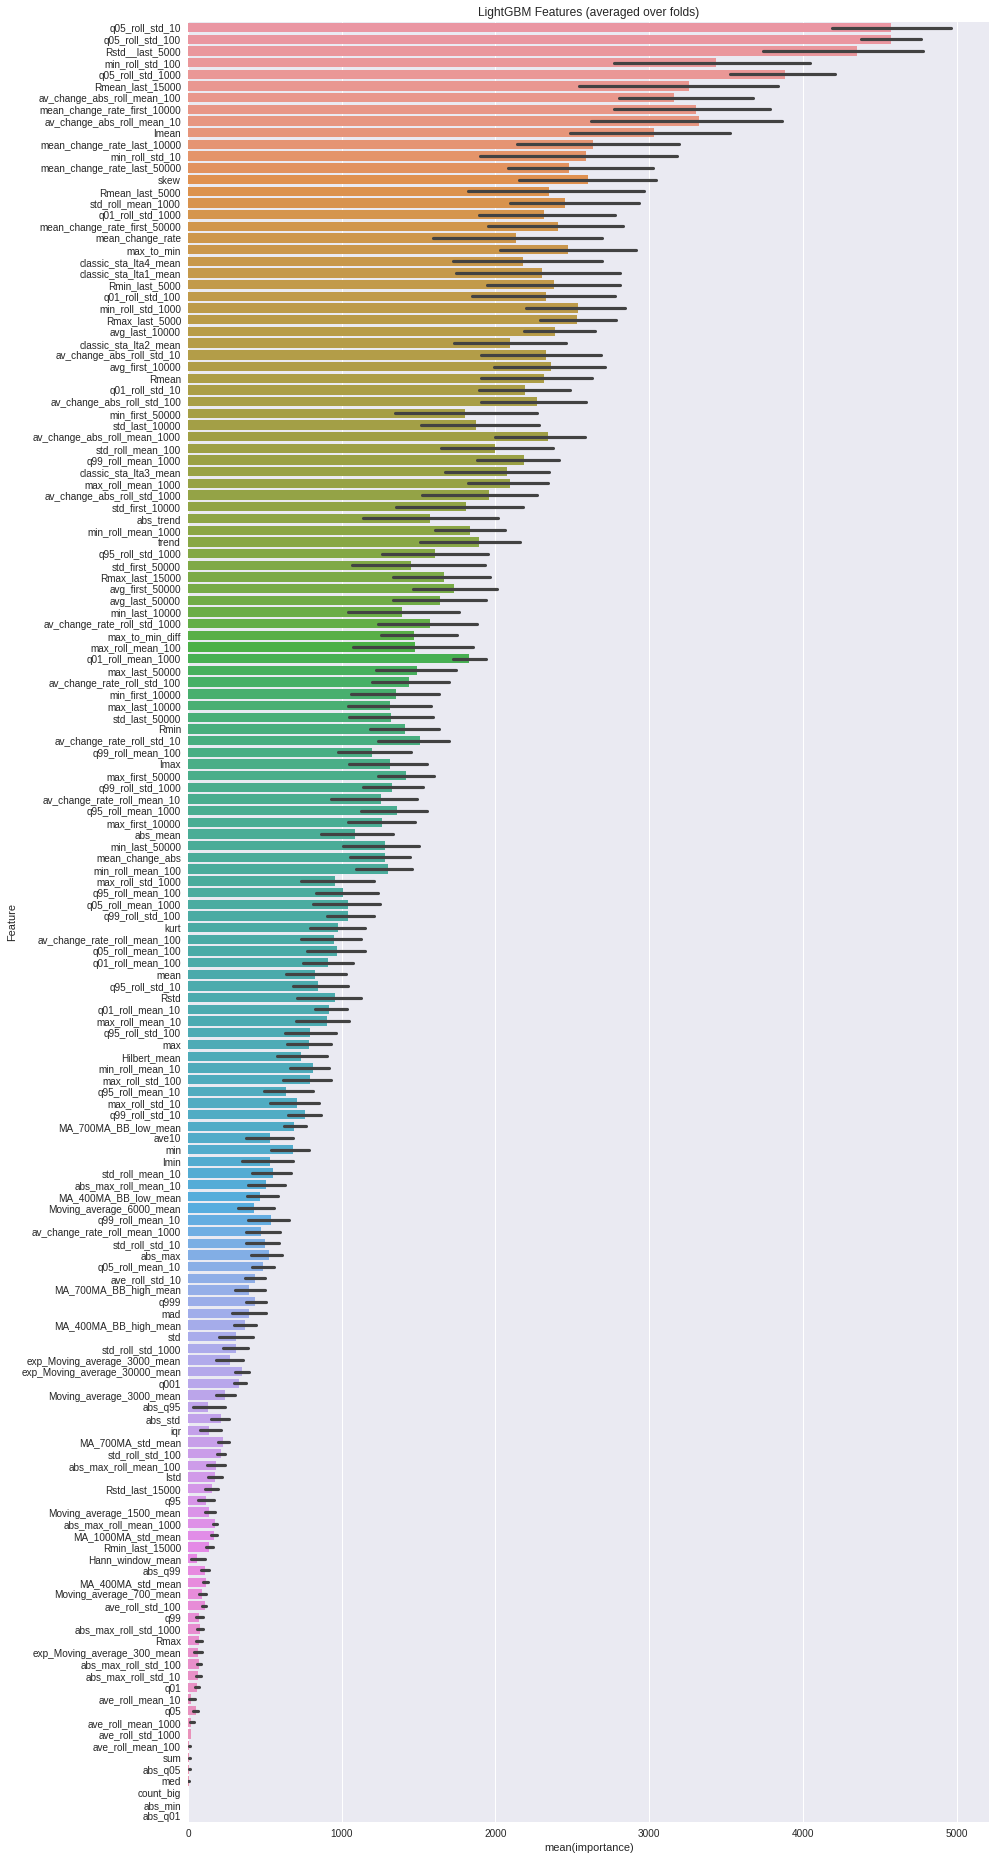

In [24]:
###### ============================ Features importance ######################
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:200].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,26))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()
plt.savefig('/content/drive/My Drive/Kaggle Competition: LANL Earthquake Prediction/lgbm_importances.png')


In [0]:


submission.time_to_failure = predictions
submission.to_csv('/content/drive/My Drive/Kaggle Competition: LANL Earthquake Prediction/submission_1.csv',index=True)



In [26]:
!kaggle competitions submit -c LANL-Earthquake-Prediction -f submission1.csv -m "V-01"

400 - Bad Request
